# Gradient descent demo
In this notebook, we train FCNs with ReLU and engineered activation functions. We include this notebook principally to make our training procedure clear. The results of training confirm that a finite-width 1HL net with engineered activation function $\tilde{\phi}$ accurately mimics the training and test performance of a finite-width 4HL ReLU net.

# Imports and installs

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

     |████████████████████████████████| 99 kB 3.0 MB/s 


In [ ]:
!pip install cifar10_web
import cifar10_web

import torchvision
from sklearn.model_selection import KFold

import time
import jax
import jax.random as random
import jax.numpy as np

import numpy as basenp

import matplotlib.pyplot as plt

import neural_tangents as nt

import utils, measures, image_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

import argparse
import os
import math

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [ ]:
key = jax.random.PRNGKey(17)

# Load UCI Data

Normalize the data so that it has 0 mean and unit variance. If desired, normalize each data point to lie on a hypersphere of radius $\sqrt{d_\text{in}}$, where $\sqrt{d_\text{in}}$ is the input dimension of the data.

In [ ]:
def normalize(train_X, test_X, uniform_radius=True):
  # NORMALIZE GLOBALLY
  train_mean = train_X.mean()
  train_std = train_X.std()
  train_X = (train_X - train_mean)/train_std
  test_X = (test_X - train_mean)/train_std
  # NORMALIZE LOCALLY
  if uniform_radius:
    # Every point lies on the surface of a hypersphere with radius sqrt(num_features)
    train_X = train_X/((train_X**2).mean(axis=1)**.5)[:,None]
    test_X = test_X/((test_X**2).mean(axis=1)**.5)[:,None]
  else:
    # On average, each point lies on the surface of a hypersphere with radius sqrt(num_features)
    train_X = train_X / np.linalg.norm(train_X, axis=1).mean() * np.sqrt(train_X.shape[1])
    test_X = test_X / np.linalg.norm(test_X, axis=1).mean() * np.sqrt(test_X.shape[1])
  
  return train_X, test_X

In [ ]:
def convert_to_our_format(train_X, train_y_labels, test_X, test_y_labels, uniform_radius=True):
  train_X = train_X.reshape((len(train_X), -1))
  test_X = test_X.reshape((len(test_X), -1))
  assert len(np.unique(train_y_labels)) == np.max(train_y_labels) + 1 == len(np.unique(test_y_labels)) == np.max(test_y_labels) + 1
  num_classes = np.max(train_y_labels) + 1
  train_y = basenp.zeros((train_y_labels.size, num_classes))   # One-hot class labels
  train_y[basenp.arange(train_y_labels.size),train_y_labels] = 1
  test_y = basenp.zeros((test_y_labels.size, num_classes))
  test_y[basenp.arange(test_y_labels.size),test_y_labels] = 1
  
  train_X, test_X = normalize(train_X, test_X, uniform_radius=uniform_radius)

  return train_X, train_y, test_X, test_y

In [ ]:
def get_cifar10(n_train=None, n_test=None, uniform_radius=True):
  train_X, train_y, test_X, test_y = cifar10_web.cifar10(path=None)

  train_X, test_X = normalize(train_X, test_X, uniform_radius=uniform_radius)

  if n_train is not None:
    train_X = train_X[:n_train]
    train_y = train_y[:n_train]
  if n_test is not None:
    test_X = test_X[:n_test]
    test_y = test_y[:n_test]

  return ((train_X, train_y), (test_X, test_y))

def get_cifar100(n_train=None, n_test=None, uniform_radius=True):
  train_Xy = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
  test_Xy = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=None)
  train_X = train_Xy.data
  train_y_labels = basenp.array(train_Xy.targets)
  test_X = test_Xy.data
  test_y_labels = basenp.array(test_Xy.targets)

  train_X = train_X.reshape((len(train_X), -1))
  test_X = test_X.reshape((len(test_X), -1))
  train_y = basenp.zeros((train_y_labels.size, 100))   # One-hot class labels
  train_y[basenp.arange(train_y_labels.size),train_y_labels] = 1
  test_y = basenp.zeros((test_y_labels.size, 100))
  test_y[basenp.arange(test_y_labels.size),test_y_labels] = 1
  
  train_X, test_X = normalize(train_X, test_X, uniform_radius=uniform_radius)

  if n_train is not None:
    train_X = train_X[:n_train]
    train_y = train_y[:n_train]
  if n_test is not None:
    test_X = test_X[:n_test]
    test_y = test_y[:n_test]

  return ((train_X, train_y), (test_X, test_y))

In [ ]:
!git clone https://github.com/LeoYu/neural-tangent-kernel-UCI.git

os.chdir('/content/neural-tangent-kernel-UCI')
!bash setup.sh

Cloning into 'neural-tangent-kernel-UCI'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 38 (delta 9), reused 8 (delta 8), pack-reused 27
Unpacking objects: 100% (38/38), done.
--2022-06-16 21:34:38--  http://persoal.citius.usc.es/manuel.fernandez.delgado/papers/jmlr/data.tar.gz
Resolving persoal.citius.usc.es (persoal.citius.usc.es)... 193.144.83.107
Connecting to persoal.citius.usc.es (persoal.citius.usc.es)|193.144.83.107|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204436099 (195M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 194.96M  10.8MB/s    in 21s     

2022-06-16 21:35:00 (9.38 MB/s) - ‘data.tar.gz’ saved [204436099/204436099]

abalone/
abalone/conxuntos_kfold.dat
abalone/abalone.arff
abalone/abalone.data
abalone/abalone.names
abalone/abalone.cost
abalone/conxuntos.dat
abalone/le_datos.m
abalone/abal

Load UCI datasets

In [ ]:
UCI_datasets = []
UCI_datasets_UR = []

datadir = "data"
MAX_N_TOT = 5000
valid_dirs = 0
for idx, dataset in enumerate(sorted(os.listdir(datadir))):
    if not os.path.isdir(datadir + "/" + dataset):
        continue
    if not os.path.isfile(datadir + "/" + dataset + "/" + dataset + ".txt"):
        continue
    dic = dict()
    for k, v in map(lambda x : x.split(), open(datadir + "/" + dataset + "/" + dataset + ".txt", "r").readlines()):
        dic[k] = v
    c = int(dic["n_clases="])
    d = int(dic["n_entradas="])
    n_train = int(dic["n_patrons_entrena="])
    n_val = int(dic["n_patrons_valida="])
    n_train_val = int(dic["n_patrons1="])
    n_test = 0
    if "n_patrons2=" in dic:
        n_test = int(dic["n_patrons2="])
    n_tot = n_train_val + n_test
    
    if n_tot > MAX_N_TOT or n_test > 0:
        print (str(dataset) + '\t0\t0')
        continue
    else:
      valid_dirs += 1
    
    print (valid_dirs-1, dataset, "\tN:", n_tot, "\td:", d, "\tc:", c)

    f = open("data/" + dataset + "/" + dic["fich1="], "r").readlines()[1:]
    X = np.asarray(list(map(lambda x: list(map(float, x.split()[1:-1])), f)))
    y = np.asarray(list(map(lambda x: int(x.split()[-1]), f)))

    fold = list(map(lambda x: list(map(int, x.split())), open(datadir + "/" + dataset + "/" + "conxuntos.dat", "r").readlines()))
    train_fold, val_fold = fold[0], fold[1]

    train_X, train_y, test_X, test_y = convert_to_our_format(X[np.array(train_fold)], y[np.array(train_fold)], X[np.array(val_fold)], y[np.array(val_fold)], uniform_radius=False)
    UCI_datasets.append((dataset, ((train_X, train_y), (test_X, test_y))))

    train_X, train_y, test_X, test_y = convert_to_our_format(X[np.array(train_fold)], y[np.array(train_fold)], X[np.array(val_fold)], y[np.array(val_fold)], uniform_radius=True)
    UCI_datasets_UR.append((dataset, ((train_X, train_y), (test_X, test_y))))

0 abalone 	N: 4177 	d: 8 	c: 3
1 acute-inflammation 	N: 120 	d: 6 	c: 2
2 acute-nephritis 	N: 120 	d: 6 	c: 2
adult	0	0
annealing	0	0
3 arrhythmia 	N: 452 	d: 262 	c: 13
audiology-std	0	0
4 balance-scale 	N: 625 	d: 4 	c: 3
5 balloons 	N: 16 	d: 4 	c: 2
6 bank 	N: 4521 	d: 16 	c: 2
7 blood 	N: 748 	d: 4 	c: 2
8 breast-cancer 	N: 286 	d: 9 	c: 2
9 breast-cancer-wisc 	N: 699 	d: 9 	c: 2
10 breast-cancer-wisc-diag 	N: 569 	d: 30 	c: 2
11 breast-cancer-wisc-prog 	N: 198 	d: 33 	c: 2
12 breast-tissue 	N: 106 	d: 9 	c: 6
13 car 	N: 1728 	d: 6 	c: 4
14 cardiotocography-10clases 	N: 2126 	d: 21 	c: 10
15 cardiotocography-3clases 	N: 2126 	d: 21 	c: 3
chess-krvk	0	0
16 chess-krvkp 	N: 3196 	d: 36 	c: 2
17 congressional-voting 	N: 435 	d: 16 	c: 2
18 conn-bench-sonar-mines-rocks 	N: 208 	d: 60 	c: 2
conn-bench-vowel-deterding	0	0
connect-4	0	0
19 contrac 	N: 1473 	d: 9 	c: 3
20 credit-approval 	N: 690 	d: 15 	c: 2
21 cylinder-bands 	N: 512 	d: 35 	c: 2
22 dermatology 	N: 366 	d: 34 	c: 6
23 echo

In [ ]:
wqr_dataset = UCI_datasets[86][1]
output_dim = wqr_dataset[0][1].shape[1]
print('Num Output Classes:', output_dim)

Num Output Classes: 6


# Varying Epochs

Train a net of fixed width and compare 1HL ReLU, 4HL ReLU, and 1HL with engineered activation function.

In [ ]:
def varying_epochs(dataset, key=key, width=4096, q=16, num_iters=3):
  ### Set up Nets
  fw_net_fns = {}
  fw_results = {}
  output_dim=dataset[0][1].shape[1]

  fw_results['train_losses'], fw_results['test_losses'], fw_results['train_accs'], fw_results['test_accs'] = {}, {}, {}, {}
  fw_net_fns['1HL relu'] = utils.get_net_fns(width, output_dim, n_hidden_layers=1, W_std=2**.5, b_std=0.1)
  fw_net_fns['4HL relu'] = utils.get_net_fns(width, output_dim, n_hidden_layers=4, W_std=2**.5, b_std=0.1)

  # Below parameters are from optimizing a 1HL kernel to match a 4HL ReLU NTK
  a7, b7, c7, d7, e7, f7, g7 = [3.8001579818118927, 1.0600013769145225, 0.09680930566346302, 0.9010060417094072, -0.07936104642025432, 11.810565331593281, 0.9340552512015492]
  phi7 = lambda z : a7*jax.nn.relu(z - b7) + c7*z + d7 + e7*np.cos(f7*z + g7)

  fw_net_fns['1HL mimic_opt_7'] = utils.get_net_fns(width, output_dim, n_hidden_layers=1, W_std=1, b_std=0, phi=phi7)

  ### Training parameters
  n_epochs = 2**q + 1
  snapshot_es = [round(e) for e in np.logspace(0, np.log10(2**q), num=8*q+1)]
  snapshot_es = basenp.unique(basenp.asarray(snapshot_es))

  ### Run training

  for arch in fw_net_fns:
    print(f'\ntraining {arch}')
    fw_results['train_losses'][arch] = []
    fw_results['test_losses'][arch] = []
    fw_results['train_accs'][arch] = []
    fw_results['test_accs'][arch] = []
    for i in range(num_iters):
      key, subkey = random.split(key)

      snapshots = utils.net_predictions(fw_net_fns[arch],
                            dataset,
                            n_epochs=n_epochs,
                            lr=.1,
                            compute_acc=True,
                            subkey=subkey,
                            print_every=n_epochs // 6,
                            snapshot_es=snapshot_es)['snapshots']

      fw_results['train_losses'][arch].append({e : utils.mse(dataset[0][1], np.array(snapshots[e]['train_preds'])) for e in snapshot_es})
      fw_results['test_losses'][arch].append({e : utils.mse(dataset[1][1], np.array(snapshots[e]['test_preds'])) for e in snapshot_es})
      fw_results['train_accs'][arch].append({e : utils.acc(dataset[0][1], np.array(snapshots[e]['train_preds'])) for e in snapshot_es})
      fw_results['test_accs'][arch].append({e : utils.acc(dataset[1][1], np.array(snapshots[e]['test_preds'])) for e in snapshot_es})
  save_dict = {}
  save_dict['results'] = fw_results
  save_dict['num_iters'] = num_iters
  save_dict['width'] = width
  save_dict['q'] = q
  save_dict['n_epochs'] = n_epochs
  save_dict['folds'] = 1
  save_dict['snapshot_es'] = snapshot_es
  save_dict['dataset'] = dataset
  save_dict['phi_coeffs_7'] = [a7, b7, c7, d7, e7, f7, g7]
  save_dict['archs'] = list(fw_net_fns.keys())
  return save_dict

def plot_results(res, loss=True):
  if loss:
    key = 'losses'
    label = 'mse'
  else:
    key = 'accs'
    label = 'acc'

  label2 = 'test'

  fig, axs = plt.subplots(ncols=2, figsize=(13, 5))

  fw_results = res['results']
  num_iters = res['num_iters']
  folds = res['folds']
  snapshot_es = res['snapshot_es']
  archs = res['archs']

  ax = axs[0]
  ax.set_xscale('log')
  for arch in archs:
    temp_dat = basenp.array([list(fw_results['train_' + key][arch][i].items()) for i in range(num_iters*folds)])
    temp_dat = temp_dat[:,:,1]
    if folds > 1:
      tds = temp_dat.shape
      temp_dat = temp_dat.reshape(folds, num_iters, tds[1])
      temp_dat = basenp.mean(temp_dat, axis=0) # Average over the folds to get single metric per random net initialization
    avg_dat = basenp.mean(temp_dat, axis=0)
    std_dat = basenp.std(temp_dat, axis=0)
    ax.plot(snapshot_es, avg_dat, label=arch)
    ax.fill_between(snapshot_es, avg_dat + std_dat, avg_dat - std_dat, alpha=0.5)
  ax.set_xlabel('epoch', fontsize=20)
  ax.set_ylabel('train ' + label, fontsize=20)
  ax.tick_params(labelsize=13)
  ax.legend(fontsize=15)

  ax = axs[1]
  ax.set_xscale('log')
  for arch in archs:
    temp_dat = basenp.array([list(fw_results['test_' + key][arch][i].items()) for i in range(num_iters*folds)])
    temp_dat = temp_dat[:,:,1]
    if folds > 1:
      tds = temp_dat.shape
      temp_dat = temp_dat.reshape(folds, num_iters, tds[1])
      temp_dat = basenp.mean(temp_dat, axis=0) # Average over the folds to get single metric per random net initialization
    #print(temp_dat.shape)
    avg_dat = basenp.mean(temp_dat, axis=0)
    std_dat = basenp.std(temp_dat, axis=0)
    #print(avg_dat, std_dat)
    ax.plot(snapshot_es, avg_dat, label=arch)
    ax.fill_between(snapshot_es, avg_dat + std_dat, avg_dat - std_dat, alpha=0.5)
  ax.set_xlabel('epoch', fontsize=20)
  ax.set_ylabel(label2 + ' ' + label, fontsize=20)
  ax.tick_params(labelsize=13)
  ax.legend(fontsize=15)

/usr/local/lib/python3.7/dist-packages/neural_tangents/_src/stax/elementwise.py:804: UserWarning: Numerical Activation Layer with fn=<function varying_epochs.<locals>.<lambda> at 0x7fe68b893b90>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'
/usr/local/lib/python3.7/dist-packages/neural_tangents/_src/stax/elementwise.py:813: UserWarning: Using JAX autodiff to compute the `fn` derivative for NTK. Beware of https://jax.readthedocs.io/en/latest/faq.html#gradients-contain-nan-where-using-where.
  'Using JAX autodiff to compute the `fn` derivative for NTK. Beware of '



training 1HL relu
Epoch		Train Loss	Test Loss		Train Acc	Test Acc
0		1.00000000	1.00000000		0.17625000	0.00625782
170		0.51956731	0.57221138		0.64749998	0.57947433
340		0.49753544	0.56684595		0.65375000	0.57947433
510		0.48234257	0.56357890		0.65749997	0.58573216
680		0.47026423	0.56127077		0.66125000	0.59198999
850		0.46006045	0.55954355		0.67624998	0.59949940
1020		0.45110354	0.55816191		0.68250000	0.60450566

training 4HL relu
Epoch		Train Loss	Test Loss		Train Acc	Test Acc
0		1.00000000	1.00000000		0.14624999	0.00625782
170		0.43559524	0.55286568		0.71625000	0.59824783
340		0.37477294	0.54385936		0.76624995	0.61827284
510		0.33283439	0.53868097		0.80624998	0.62453067
680		0.30088982	0.53533298		0.84125000	0.63078851
850		0.27518019	0.53312707		0.85499996	0.62953693
1020		0.25379211	0.53194875		0.86500001	0.62703383

training 1HL mimic_opt_7
Epoch		Train Loss	Test Loss		Train Acc	Test Acc
0		1.00000000	1.00000000		0.13499999	0.13892366
170		0.43747574	0.54904729		0.72375000	0.59949

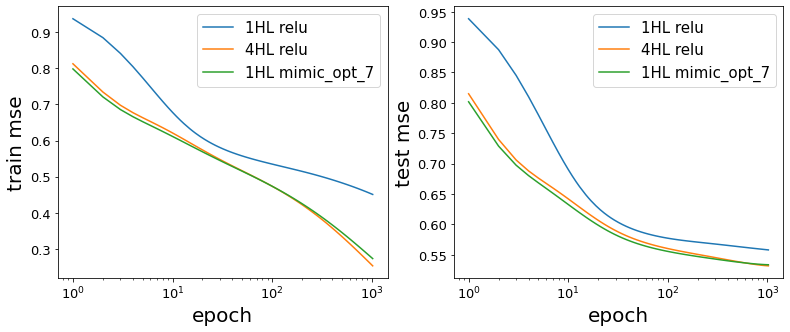

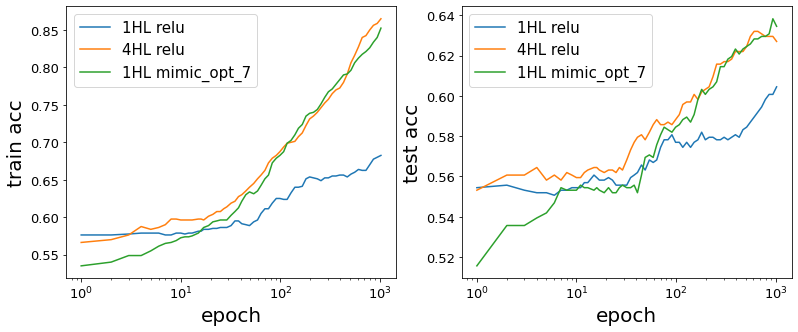

In [ ]:
res = varying_epochs(wqr_dataset, q=10, num_iters=1)
plot_results(res, loss=True)
plot_results(res, loss=False)